In [1]:
# https://github.com/swar/nba_api
import nba
import re 
from enum import Enum
import matplotlib.pyplot as plt
from scipy.stats import poisson
import numpy as np
import sklearn
import pandas as pd
# model building
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline


# model performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
%load_ext autoreload
%autoreload 2

In [2]:
#from nba_api.stats.endpoints import TeamVsPlayer
#from nba_api.stats.endpoints import PlayerVsPlayer
#from nba_api.stats.endpoints import PlayerProfileV2
#from nba_api.stats.endpoints import PlayerNextNGames
from nba_api.stats.endpoints import PlayerGameLogs
#from nba_api.stats.endpoints import BoxScorePlayerTrackV3

from nba_api.stats.endpoints import * # doing this means I have to type the name of the script as well
from nba_api.stats.endpoints import LeagueStandingsV3
from nba_api.stats.endpoints import DefenseHub



In [142]:
#id = game_ids.iloc[0]
team_id = nba.get_team_dict('UTA')['id']
player_id = nba.get_player_dict('Jamal Murray')['id']
vs_player_id = nba.get_player_dict('Anthony Davis')['id']
season_id = 2022 # we are in the 2024 season, there are no standings for this season currently

'''
Why are these only giving me one datapoint
'''

# TeamVsPlayer(player_id,team_id, last_n_games = 50).get_data_frames()[0] # how does a player do when they play against
# PlayerVsPlayer(player_id,vs_player_id).get_data_frames()[0] # how does a player do when they player against
# PlayerProfileV2(player_id).get_data_frames()[0] # season data for every season
# PlayerNextNGames(player_id).get_data_frames()[0] # what is the schedule for this player ?
# playergamelog.PlayerGameLog(player_id).get_data_frames()[0] # is this different than box score?
# LeagueStandingsV3(season = season_id).get_data_frames()[0]
# DefenseHub()#.get_data_frames()[0]

'\nWhy are these only giving me one datapoint\n'

In [ ]:
# Task: Build Multiple Linear Regression
# 1. Turn model training into functions
# Task: Improve linear regression: include more than the previous games data
# 1. check that get_data isn't giveing us the game we are predicting in the dataset
# 2. 
# Task: Build a new Model

In [86]:
game_ids = current_season['GAME_ID']
nba.get_single_game(current_season, game_ids.iloc[0])

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN
0,0012300064,2,12,0,1,10:11 PM,12:00,None,Start of 1st Period (10:11 PM EST),None,None,None
1,0012300064,4,10,0,1,10:11 PM,12:00,Jump Ball Zubac vs. Jokic: Tip to Hyland,None,None,None,None
2,0012300064,7,2,63,1,10:12 PM,11:39,MISS Mann 4' Fadeaway Jumper,None,None,None,None
3,0012300064,8,4,0,1,10:12 PM,11:34,None,None,Gordon REBOUND (Off:0 Def:1),None,None
4,0012300064,9,5,2,1,10:12 PM,11:28,Covington STEAL (1 STL),None,Gordon Lost Ball Turnover (P1.T1),None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
461,0012300064,638,2,2,4,12:26 AM,0:15,MISS Moon 26' 3PT Running Jump Shot,None,None,None,None
462,0012300064,639,4,0,4,12:26 AM,0:13,Diabate REBOUND (Off:2 Def:1),None,None,None,None
463,0012300064,640,2,97,4,12:26 AM,0:13,MISS Diabate Tip Layup Shot,None,None,None,None
464,0012300064,641,4,0,4,12:26 AM,0:12,None,None,Watson REBOUND (Off:1 Def:2),None,None


In [4]:
#nba.BoxScoreAdvancedV3(games['GAME_ID'].iloc[0]).get_data_frames()[0]
#BoxScorePlayerTrackV3(games['GAME_ID'].iloc[0]).get_data_frames()[0]
#player_id = nba.get_player_dict(player)['id']
#player_id
def get_data(box, var, n_games = 1):
    '''
    create games of interest from the box scores we are given
    '''
    # get the index that starts the useful data
    if 'minutes' in box.columns:
        min_index = list(box.columns).index('minutes')
    elif 'MIN' in box.columns:
        min_index = list(box.columns).index('MIN')
        
    data = box.iloc[:,min_index:].reset_index(drop = True)
    # build our training data framework where the previous game predicts a single stat from our last game

    y = data[var]
    # take the most recent game in the dataset and throw it our
    data = data.iloc[y.index[1:]].reset_index(drop = True)
    data['next_game_%s'%var] = y[:-1]
    return data




In [3]:
# define the team and the player that we are looking at
team, player = 'DEN', 'Jamal Murray'
# retrieve the player id that we are interested in 
player_id = nba.get_player_dict(player)['id']
# game logs is all of the box scores of that season. The season variable is a bit odd, it's a string like this '2022-23'
game_logs = nba.get_game_logs(player_id, season = '2022-23')
# where does our data start
min_index = list(game_logs.columns).index('MIN')
# what are the possible datapoints that we can predict
vars = game_logs.columns[list(game_logs.columns).index('MIN'):]
var = vars[0]
# return the previous game with the last column of target data
#data = nba.get_data(game_logs,vars[0])
data = get_data(game_logs, var[0], 5)
#data

NameError: name 'get_data' is not defined

In [70]:
var = 'REB'
# remove the target feature from X and keep in it y
X, y = data.drop(columns = 'next_game_%s'%var), data['next_game_%s'%var]
#  split the data, change our X data to numpy so that the feature columns don't have feature names
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2, random_state=42)
# we need to build a scaler on the training data
scaler = preprocessing.StandardScaler().fit(X_train)
# I am curious what the mean and scale is of the data
#print(scaler.mean_, scaler.scale_)
# Scaled data has zero mean and unit variance:
X_scaled = scaler.transform(X_train)
# train and fit a linearRegression on the scaled data
model = LinearRegression()
model.fit(X_train,y_train)

nba.print_performance_stats(model,X_scaled, scaler.transform(X_test), y_train, y_test)

TRAINING
------------------------------
r2: -0.7752465517894651
MSE: 8.65355643365776
RMSE: 2.9416927836974684
MAE 2.3768314312428958 

TESTING
------------------------------
r2: -1.090853787968887
MSE: 5.619169555166384
RMSE: 2.3704787607499007
MAE 1.9109313356327773 


In [56]:
var = 'REB'
box = game_logs
min_index = list(box.columns).index('MIN')
data = box.iloc[:,min_index:].reset_index(drop = True)
y = data[var]
data.iloc[y.index[1:]].reset_index(drop = True)

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG
0,9.466667,1,2,0.500,0,1,0.000,0,0,0.00,...,1,17,58,65,32,65,6,2,65,1
1,41.496667,10,21,0.476,3,8,0.375,3,3,1.00,...,38,31,2,9,29,7,6,2,8,1
2,35.883333,6,15,0.400,4,10,0.400,5,5,1.00,...,1,17,10,27,62,28,6,2,26,1
3,35.766667,8,14,0.571,3,6,0.500,0,0,0.00,...,1,52,22,35,35,27,6,2,26,1
4,32.766667,9,19,0.474,5,10,0.500,3,4,0.75,...,1,52,22,9,16,9,6,2,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,20.550000,5,9,0.556,2,4,0.500,1,2,0.50,...,1,1,10,54,44,63,6,2,62,1
60,27.716667,6,15,0.400,1,7,0.143,0,0,0.00,...,1,17,58,54,11,50,6,2,49,1
61,26.616667,3,12,0.250,2,4,0.500,0,2,0.00,...,38,31,47,61,61,64,6,2,64,1
62,27.491667,6,12,0.500,1,4,0.250,3,4,0.75,...,1,1,36,46,25,48,6,2,47,1


In [6]:
# define the team and the player that we are looking at
team, player = 'DEN', 'Jamal Murray'
# retrieve the player id that we are interested in 
player_id = nba.get_player_dict(player)['id']
# game logs is all of the box scores of that season. The season variable is a bit odd, it's a string like this '2022-23'
game_logs = nba.get_game_logs(player_id, season = '2022-23')
# where does our data start
min_index = list(game_logs.columns).index('MIN')
# what are the possible datapoints that we can predict
vars = game_logs.columns[list(game_logs.columns).index('MIN'):]
var = vars[0]
# return the previous game with the last column of target data
#data = nba.get_data(game_logs,vars[0])

In [44]:

# remove the target feature from X and keep in it y
X, y = data.drop(columns = 'next_game_%s'%var), data['next_game_%s'%var]
#  split the data, change our X data to numpy so that the feature columns don't have feature names
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2, random_state=42)
# we need to build a scaler on the training data
scaler = preprocessing.StandardScaler().fit(X_train)
# I am curious what the mean and scale is of the data
#print(scaler.mean_, scaler.scale_)
# Scaled data has zero mean and unit variance:
X_scaled = scaler.transform(X_train)
# train and fit a linearRegression on the scaled data
model = LinearRegression()
model.fit(X_train,y_train)

nba.print_performance_stats(model,X_scaled, scaler.transform(X_test), y_train, y_test)

# Let's make a pipeline so that we can use any other kind of model that we'd like
# I haven't used pipe before so if we run into errors lets read the docs

#pipe = make_pipeline(StandardScaler(), LinearRegression())
#pipe.fit(X_train, y_train)  # apply scaling on training data
#Pipeline(steps=[('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression())])



LinearRegression()

In [47]:
# where does our data start
min_index = list(game_logs.columns).index('MIN')
# what are the possible datapoints that we can predict
vars = game_logs.columns[list(game_logs.columns).index('MIN'):]
var = vars[0]
# return the previous game with the last column of target data
data = nba.get_data(game_logs,vars[0])
# remove the target feature from X and keep in it y
X, y = data.drop(columns = 'next_game_%s'%var), data['next_game_%s'%var]
#  split the data, change our X data to numpy so that the feature columns don't have feature names
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2, random_state=42)
# we need to build a scaler on the training data, scaling the target feature isn't always necassary
X_scaler = preprocessing.StandardScaler().fit(X_train)
# Scaled data has zero mean and unit variance:
X_scaled = X_scaler.transform(X_train)

# train and fit a linearRegression on the scaled data
model = LinearRegression()
model.fit(X_scaled,y_train)

nba.print_performance_stats(model,X_scaled, X_scaler.transform(X_test), y_train, y_test)

TRAINING
------------------------------
accuracy: 0.1568627450980392
r2: 0.8789423712021136
MSE: 4.509803921568627

TESTING
------------------------------
accuracy: 0.0
r2: -41.134553283100104
MSE: 463.2307692307692


In [5]:
# this model sucks! let's try preprocessing
models = []
scalers = []
vars = game_logs.columns[list(game_logs.columns).index('MIN'):]
for var in vars:
    data = nba.get_data(game_logs, var, 2)
    X, y = data.drop(columns = 'next_game_%s'%var), data['next_game_%s'%var]
    #print(X.columns.index()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    # we need to build a scaler on the training data, scaling the target feature isn't always necassary
    X_scaler = preprocessing.StandardScaler().fit(X_train)
    # Scaled data has zero mean and unit variance:
    X_scaled = X_scaler.transform(X_train)
    print(len(X_scaled))

    model.fit(X_scaled,y_train)
    print(var)
    nba.print_performance_stats(model,X_scaled, X_scaler.transform(X_test), y_train, y_test)
    print()
    models.append(model)
    scalers.append(X_scaler)

50
MIN
TRAINING
------------------------------
r2: 1.0
MSE: 2.2927453349343486e-28
RMSE: 1.514181407538195e-14
MAE 1.1688428003253648e-14 

TESTING
------------------------------
r2: -5.162732015411652
MSE: 184.21215212236442
RMSE: 13.57247774440483
MAE 11.783793859589075 

50
FGM
TRAINING
------------------------------
r2: 1.0
MSE: 3.75024474342069e-29
RMSE: 6.123924185863742e-15
MAE 5.169198402654729e-15 

TESTING
------------------------------
r2: -3.5477462793111556
MSE: 43.10940555891403
RMSE: 6.565775320471606
MAE 5.228055160862815 

50
FGA
TRAINING
------------------------------
r2: 1.0
MSE: 1.308246925218526e-28
RMSE: 1.1437862235656303e-14
MAE 8.348877145181177e-15 

TESTING
------------------------------
r2: -5.539210974925269
MSE: 129.623412816566
RMSE: 11.385227833318313
MAE 10.527005049426112 

50
FG_PCT
TRAINING
------------------------------
r2: 1.0
MSE: 1.3939110565497058e-31
RMSE: 3.733511827421611e-16
MAE 2.9698465908722935e-16 

TESTING
------------------------------

In [84]:
for var, model in zip(vars, models):
    print(var)
    coef = np.round(model.coef_,2)
    print(coef[66:])
    print(coef[:66])
    

MIN
[-1.69 -1.43 -1.72  0.4  -1.6   1.24 -0.99 -0.46 -2.35 -0.49  4.06 -1.74
  0.2   1.34 -1.73  0.    1.03  1.03  1.03 -1.42 -1.44 -0.05  1.54  0.06
 -1.66 -0.37  3.8   0.18  2.91  2.39 -0.81 -3.77  0.76 -1.71  0.72  1.08
 -0.96 -0.28 -2.65 -2.16  0.84 -1.56 -0.2  -1.34 -0.76  0.  ]
[-1.08 -1.2   0.16  1.69 -1.34 -2.65 -0.9  -0.58 -0.6  -1.77  2.67  1.61
 -0.42 -0.32  2.92 -0.9   1.12  0.47 -2.76 -0.69 -1.5   0.44  0.72  0.
  0.44 -0.   -0.29 -0.29 -0.29  1.4   1.29 -0.67  1.24 -2.1   1.19  1.03
 -0.14 -3.09 -1.2   0.42  5.22 -2.88  0.77  1.49  2.05  1.34 -0.43 -0.02
  1.7  -0.88 -0.04  0.07 -0.72  0.   -2.22  0.   -0.45  2.31  0.59 -2.55
 -1.05  3.05  1.65  2.23  0.39 -0.1 ]
FGM
[ 0.35  0.14 -0.74  1.81  0.55 -0.86 -0.57  0.69 -1.19  0.08  0.09 -0.47
 -0.33  0.6  -0.09  0.   -0.13 -0.13 -0.13 -0.97 -0.14  0.28  1.23  0.29
  1.03  0.83 -0.65  0.91  0.22  0.69 -0.6   0.4   1.11 -0.38  0.77  0.3
 -0.54  0.28 -1.45 -1.13 -0.47  0.19  0.33 -0.6   0.08  0.  ]
[-0.01 -0.02 -1.   -0.   -0.37

In [6]:
var = 'PTS'
data = nba.get_data(game_logs, var, 2)
X, y = data.drop(columns = 'next_game_%s'%var), data['next_game_%s'%var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

var_index = list(game_logs.columns).index(var) 
nba.plot_prediction(models[var_index], scalers[var_index].transform(X_train),
                    scalers[var_index].transform(X_test),
                    y_train,
                    y_test,
                    
                    'linear regression', var)

TypeError: get_data() missing 1 required positional argument: 'n_games'

In [4]:
# get all the games that 
team, player = 'DEN', 'Jamal Murray'
player_id = nba.get_player_dict(player)['id']
# this took a couple of mins for only 99 game entries
games = nba.get_team_games_years(team,[2022, 2023], start = None) # returns data from that season
box = nba.get_player_box(games,player)
box['minutes'] = box['minutes'].replace('','00:00')
box['minutes'] = box['minutes'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1]) / 60)
#current_box
var = 'points'
data = get_data(box, var)




ReadTimeout: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)

In [80]:
y_test

52    21
58    24
0     20
44    21
5     26
36    14
16    32
12    24
25    26
61    13
56    19
9     19
40     6
Name: next_game_PTS, dtype: int64

In [155]:

#nba.print_performance_stats(model,X_train, X_test, y_train, y_test)


IndentationError: expected an indented block after 'for' statement on line 1 (2752534630.py, line 2)

In [40]:
#get_prob(current_box, 'points', 22.5)
keys = ['threePointersMade','freeThrowsMade','fieldGoalsMade'  ]
for var in keys:
    for val in np.arange(20):
        print(var,val, get_prob(current_box,var, val))

threePointersMade 0 (0.6, 0.6, 0.5488116360940265)
threePointersMade 1 (0.6, 0.6, 0.8780986177504424)
threePointersMade 2 (0.6, 0.6, 0.9768847122473671)
threePointersMade 3 (0.6, 0.6, 0.996641931146752)
threePointersMade 4 (0.6, 0.6, 0.9996055139816598)
threePointersMade 5 (0.6, 0.6, 0.9999611439218486)
threePointersMade 6 (0.6, 0.6, 0.9999967069158676)
threePointersMade 7 (0.6, 0.6, 0.9999997551724977)
threePointersMade 8 (0.6, 0.6, 0.999999983791745)
threePointersMade 9 (0.6, 0.6, 0.9999999990330282)
threePointersMade 10 (0.6, 0.6, 0.9999999999475052)
threePointersMade 11 (0.6, 0.6, 0.9999999999973858)
threePointersMade 12 (0.6, 0.6, 0.9999999999998798)
threePointersMade 13 (0.6, 0.6, 0.9999999999999949)
threePointersMade 14 (0.6, 0.6, 0.9999999999999998)
threePointersMade 15 (0.6, 0.6, 1.0)
threePointersMade 16 (0.6, 0.6, 1.0)
threePointersMade 17 (0.6, 0.6, 1.0)
threePointersMade 18 (0.6, 0.6, 1.0)
threePointersMade 19 (0.6, 0.6, 1.0)
freeThrowsMade 0 (2.0, 2.0, 0.1353352832366127)

In [32]:
# renamed poission




get_prob(current_box, 'points', 22.5)

(9.4, 9.4, 0.9998751024258753)

(9.4, 9.4, 0.9998751024258753)

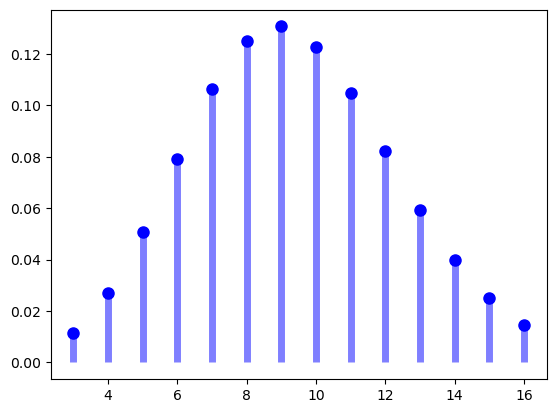

In [66]:
# 2. Use a probability mass function to estimate the proability of achieving a specific value


plot_pmf(current_box, 'points')

In [4]:
games = nba.get_team_games_years('DEN',[2022,2023], start = None)
# this took a couple of mins for only 99 game entries
box = nba.get_player_box(games, 'Jamal Murray')

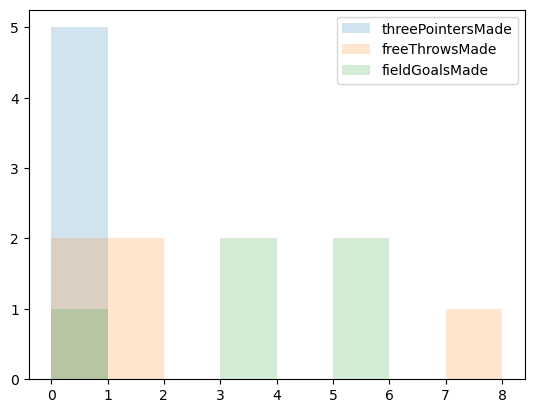

In [69]:
# 1. Look at the mass function of these values for the previous year (since we only have the first couple of games we won't know what the distribution looks like)

plot_distributions(current_box,['threePointersMade','freeThrowsMade','fieldGoalsMade'  ])

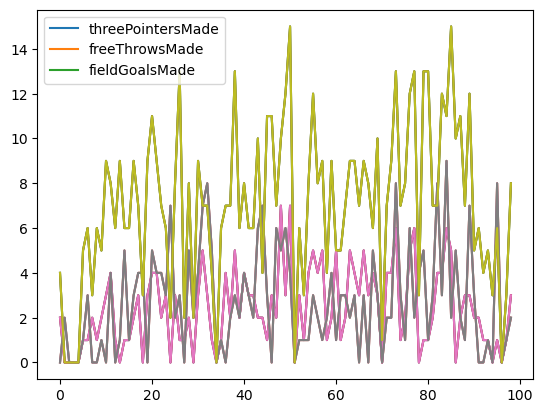

In [73]:
# points over time
#keys = ['threePointersMade','freeThrowsMade','fieldGoalsMade'  ]




plot_stat_over_games(box, ['threePointersMade','freeThrowsMade','fieldGoalsMade'  ])

In [51]:
mu = box['points'].mean()
print(mu)
# probability of being less than val
val = 10
poisson.cdf(val, mu)


19.282828282828284


0.01581699045643929

In [1]:
box.describe()

NameError: name 'box' is not defined

In [209]:
print(game_id)
games

0012300021


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
1,12023,1610612743,DEN,Denver Nuggets,0012300064,2023-10-19,DEN @ LAC,W,239,103,...,0.783,11,36,47,27,7,3,15,22,13.0
2,12023,1610612743,DEN,Denver Nuggets,0012300055,2023-10-17,DEN @ LAC,L,239,103,...,0.792,12,28,40,23,13,2,12,18,-13.0
3,12023,1610612743,DEN,Denver Nuggets,0012300042,2023-10-15,DEN vs. CHI,W,242,116,...,0.667,5,34,39,25,4,9,10,18,14.0
4,12023,1610612743,DEN,Denver Nuggets,0012300030,2023-10-12,DEN @ CHI,L,290,124,...,0.769,10,29,39,35,14,10,27,22,-9.0
5,12023,1610612743,DEN,Denver Nuggets,0012300021,2023-10-10,DEN @ PHX,W,241,115,...,0.867,8,29,37,32,11,6,13,23,8.0


In [208]:

print(box_score.columns)

#player_game_data['fieldGoalsMade']
player_game_data
#player_game_data[['fieldGoalsMade','threePointersMade','freeThrowsMade']]

Index(['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug',
       'personId', 'firstName', 'familyName', 'nameI', 'playerSlug',
       'position', 'comment', 'jerseyNum', 'minutes', 'fieldGoalsMade',
       'fieldGoalsAttempted', 'fieldGoalsPercentage', 'threePointersMade',
       'threePointersAttempted', 'threePointersPercentage', 'freeThrowsMade',
       'freeThrowsAttempted', 'freeThrowsPercentage', 'reboundsOffensive',
       'reboundsDefensive', 'reboundsTotal', 'assists', 'steals', 'blocks',
       'turnovers', 'foulsPersonal', 'points', 'plusMinusPoints'],
      dtype='object')


,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,...,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
4,0012300021,1610612743,Denver,Nuggets,DEN,nuggets,1627750,Jamal,Murray,J. Murray,...,1,0,1,5,2,0,0,2,12,12.0


In [143]:
p = re.compile('\(\d')
df = get_single_game(games, games['GAME_ID'][2])
points = df.loc[df['EVENTMSGTYPE'].isin([1,3])]
player_name = 'Murray'
name_len, p = len(player_name), re.compile('\(\d+')

final_string = points[points.VISITORDESCRIPTION.str[:name_len] == name]['VISITORDESCRIPTION'].iloc[-1]
result = p.search(final_string).group(0)
print(result)

IndexError: single positional indexer is out-of-bounds

In [85]:
print(f'EVENTMSGTYPE: {sorted(df.EVENTMSGTYPE.unique())}')

#For quick refernce, here's an Enum for `EVENTMSGTYPE`
#This list may be incomplete as a thourogh play by play scan is necessary



class EventMsgType(Enum):
    FIELD_GOAL_MADE = 1
    FIELD_GOAL_MISSED = 2
    FREE_THROWfree_throw_attempt = 3
    REBOUND = 4
    TURNOVER = 5
    FOUL = 6
    VIOLATION = 7
    SUBSTITUTION = 8
    TIMEOUT = 9
    JUMP_BALL = 10
    EJECTION = 11
    PERIOD_BEGIN = 12
    PERIOD_END = 13

#### pull the data for a specfic EVENTMSGTYPE
points = df.loc[df['EVENTMSGTYPE'].isin([1,3])]#.head() #hint: use the EVENTMSGTYPE values above to see different data
points[(points.VISITORDESCRIPTION.str[0] == 'Murray').fillna(False)]

EVENTMSGTYPE: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 18]


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN


8

In [24]:
# Subset the games to where MATCHUP contains the other teams abbrevations 'TOR'.
op_team = 'LAC'
recent_op_team = recent[recent.MATCHUP.str.contains(op_team.upper())]
recent_op_team.head()
# sort by game date and last row
last_op_game = recent_op_team.sort_values('GAME_DATE').iloc[-1]
game_id = last_op_game['GAME_ID']

# here we pull the game data for both teams. It can get kind of slow since we filter the game id against "all" games 

# Get **all** the games so we can filter to an individual GAME_ID
result = leaguegamefinder.LeagueGameFinder()
all_games = result.get_data_frames()[0]
# Find the game_id we want
full_game = all_games[all_games.GAME_ID == game_id]
full_game


# check examples for how to combine these two into one row and look at the play by play data

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
18,12023,1610612746,LAC,LA Clippers,0012300064,2023-10-19,LAC vs. DEN,L,240,90,...,0.615,12,34,46,18,11,2,17,20,-13.0
22,12023,1610612743,DEN,Denver Nuggets,0012300064,2023-10-19,DEN @ LAC,W,239,103,...,0.783,11,36,47,27,7,3,15,22,13.0


In [ ]:
df = playbyplay.PlayByPlay(game_id).get_data_frames()[0]